In [1]:
library(limma)
library(survival)
library(survminer)
library(msigdbr)
library(clusterProfiler)
library(enrichplot)
library(ComplexHeatmap)
library(GSVA)
library(reshape2)

TCGA_PanCancer = readRDS("/srv/shiny-server/SNVIO_V10.1/data/TCGA/panacanlt_TCGA_log2.rds")
pathway_list = readRDS("/srv/shiny-server/SNVIO_V10.1/data/all_pathway.rds")

Loading required package: ggplot2

Loading required package: ggpubr



Bioconductor version '3.12' is out-of-date; the current release version '3.19'
  is available with R version '4.4'; see https://bioconductor.org/install

clusterProfiler v3.18.1  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘enrichplot’


The following object is masked from ‘package:ggpubr’:

    color_palette


Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: htt

In [2]:
# 第一步：将所有瘤种的补体突变患者和野生型患者区分开来
TCGA_cohort_cal_pm = function(TCGA,cancer_type,gene,Mut_type,Wild_type){
  if("All" %in% Mut_type){
    mut = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode[
      TCGA[[cancer_type]]$maf@data$Hugo_Symbol %in% pathway_list[[gene]]
    ]))
  }else{
    mut = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode[
      TCGA[[cancer_type]]$maf@data$Hugo_Symbol %in% pathway_list[[gene]] &
        TCGA[[cancer_type]]$maf@data$Variant_Classification %in% Mut_type
    ]))
  }
  
  if(Wild_type == "Others"){
    wt = setdiff(x = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode)),mut) 
  }else{
    wt = setdiff(x = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode)),
                 unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode[TCGA[[cancer_type]]$maf@data$Hugo_Symbol %in% pathway_list[[gene]]])))
  }
  return(list("mut" = mut,"wt" = wt))
}

### GOBP_THYMUS_DEVELOPMENT

In [3]:
anno = vector()
Complement_Mut_matrix = NA
Complement_Wt_matrix = NA
for(i in setdiff(names(TCGA_PanCancer),c("DLBC","LAML"))){
    tmp_cohort = TCGA_cohort_cal_pm(TCGA_PanCancer,i,"GOBP_THYMUS_DEVELOPMENT","All","Others")
    RNA_ID = colnames(TCGA_PanCancer[[i]]$rna)
    tmp_mut = intersect(tmp_cohort$mut,RNA_ID)
    tmp_wt = intersect(tmp_cohort$wt,RNA_ID)
    Complement_Mut_matrix = cbind(Complement_Mut_matrix,TCGA_PanCancer[[i]]$rna[tmp_mut])
    Complement_Wt_matrix = cbind(Complement_Wt_matrix,TCGA_PanCancer[[i]]$rna[tmp_wt])
    anno = rbind(anno,data.frame(Patient=tmp_mut,Cancer_Type=rep(i,length(tmp_mut)),Complement=rep("Mutation",length(tmp_mut))))
    anno = rbind(anno,data.frame(Patient=tmp_wt,Cancer_Type=rep(i,length(tmp_wt)),Complement=rep("Wildtype",length(tmp_wt))))
    
}
rownames(anno) = anno$Patient
anno$Patient = NULL

Complement_Mut_matrix$Complement_Mut_matrix = NULL
Complement_Wt_matrix$Complement_Wt_matrix = NULL

In [4]:
All_RNA = cbind(Complement_Mut_matrix,Complement_Wt_matrix)

In [5]:
m = apply(All_RNA,1,function(x){sum(x>0)>ncol(Complement_Mut_matrix)})
tmp_data = All_RNA[m,]

In [6]:
group = factor(c(rep("Mutation",ncol(Complement_Mut_matrix)),rep("Wildtype",ncol(Complement_Wt_matrix))),levels = c("Mutation","Wildtype"))
design = model.matrix(~0+group)
rownames(design) = colnames(tmp_data)
colnames(design) = c("Mutation","Wildtype")
  
fit = lmFit(tmp_data,design)
contr = makeContrasts(Mutation-Wildtype,levels = design)
diff = contrasts.fit(fit,contr)
diff = eBayes(diff)
tab = topTable(diff, sort.by = "P", n = Inf)

In [7]:
FC = tab$logFC
names(FC) = rownames(tab)
FC = sort(FC,decreasing = T)

In [8]:
KEGG = msigdbr(species="Homo sapiens",category="C2",subcategory = "CP:KEGG") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
REACTOME = msigdbr(species="Homo sapiens",category="C2",subcategory = "CP:REACTOME") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
HALLMARK = msigdbr(species="Homo sapiens",category="H") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
GO_BP = msigdbr(species="Homo sapiens",category="C5",subcategory = "GO:BP") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
GO_CC = msigdbr(species="Homo sapiens",category="C5",subcategory = "GO:CC") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
GO_MF = msigdbr(species="Homo sapiens",category="C5",subcategory = "GO:MF") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)

In [9]:
res = GSEA(geneList = FC,TERM2GENE = GO_BP[,c(1,3)],pvalueCutoff = 1)

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



In [11]:
x2 <- pairwise_termsim(res,showCategory = 100)
p = emapplot(x2,showCategory = 100,color="NES",min_edge = 0.25,layout = "fr")

Warning message:
“ggrepel: 53 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


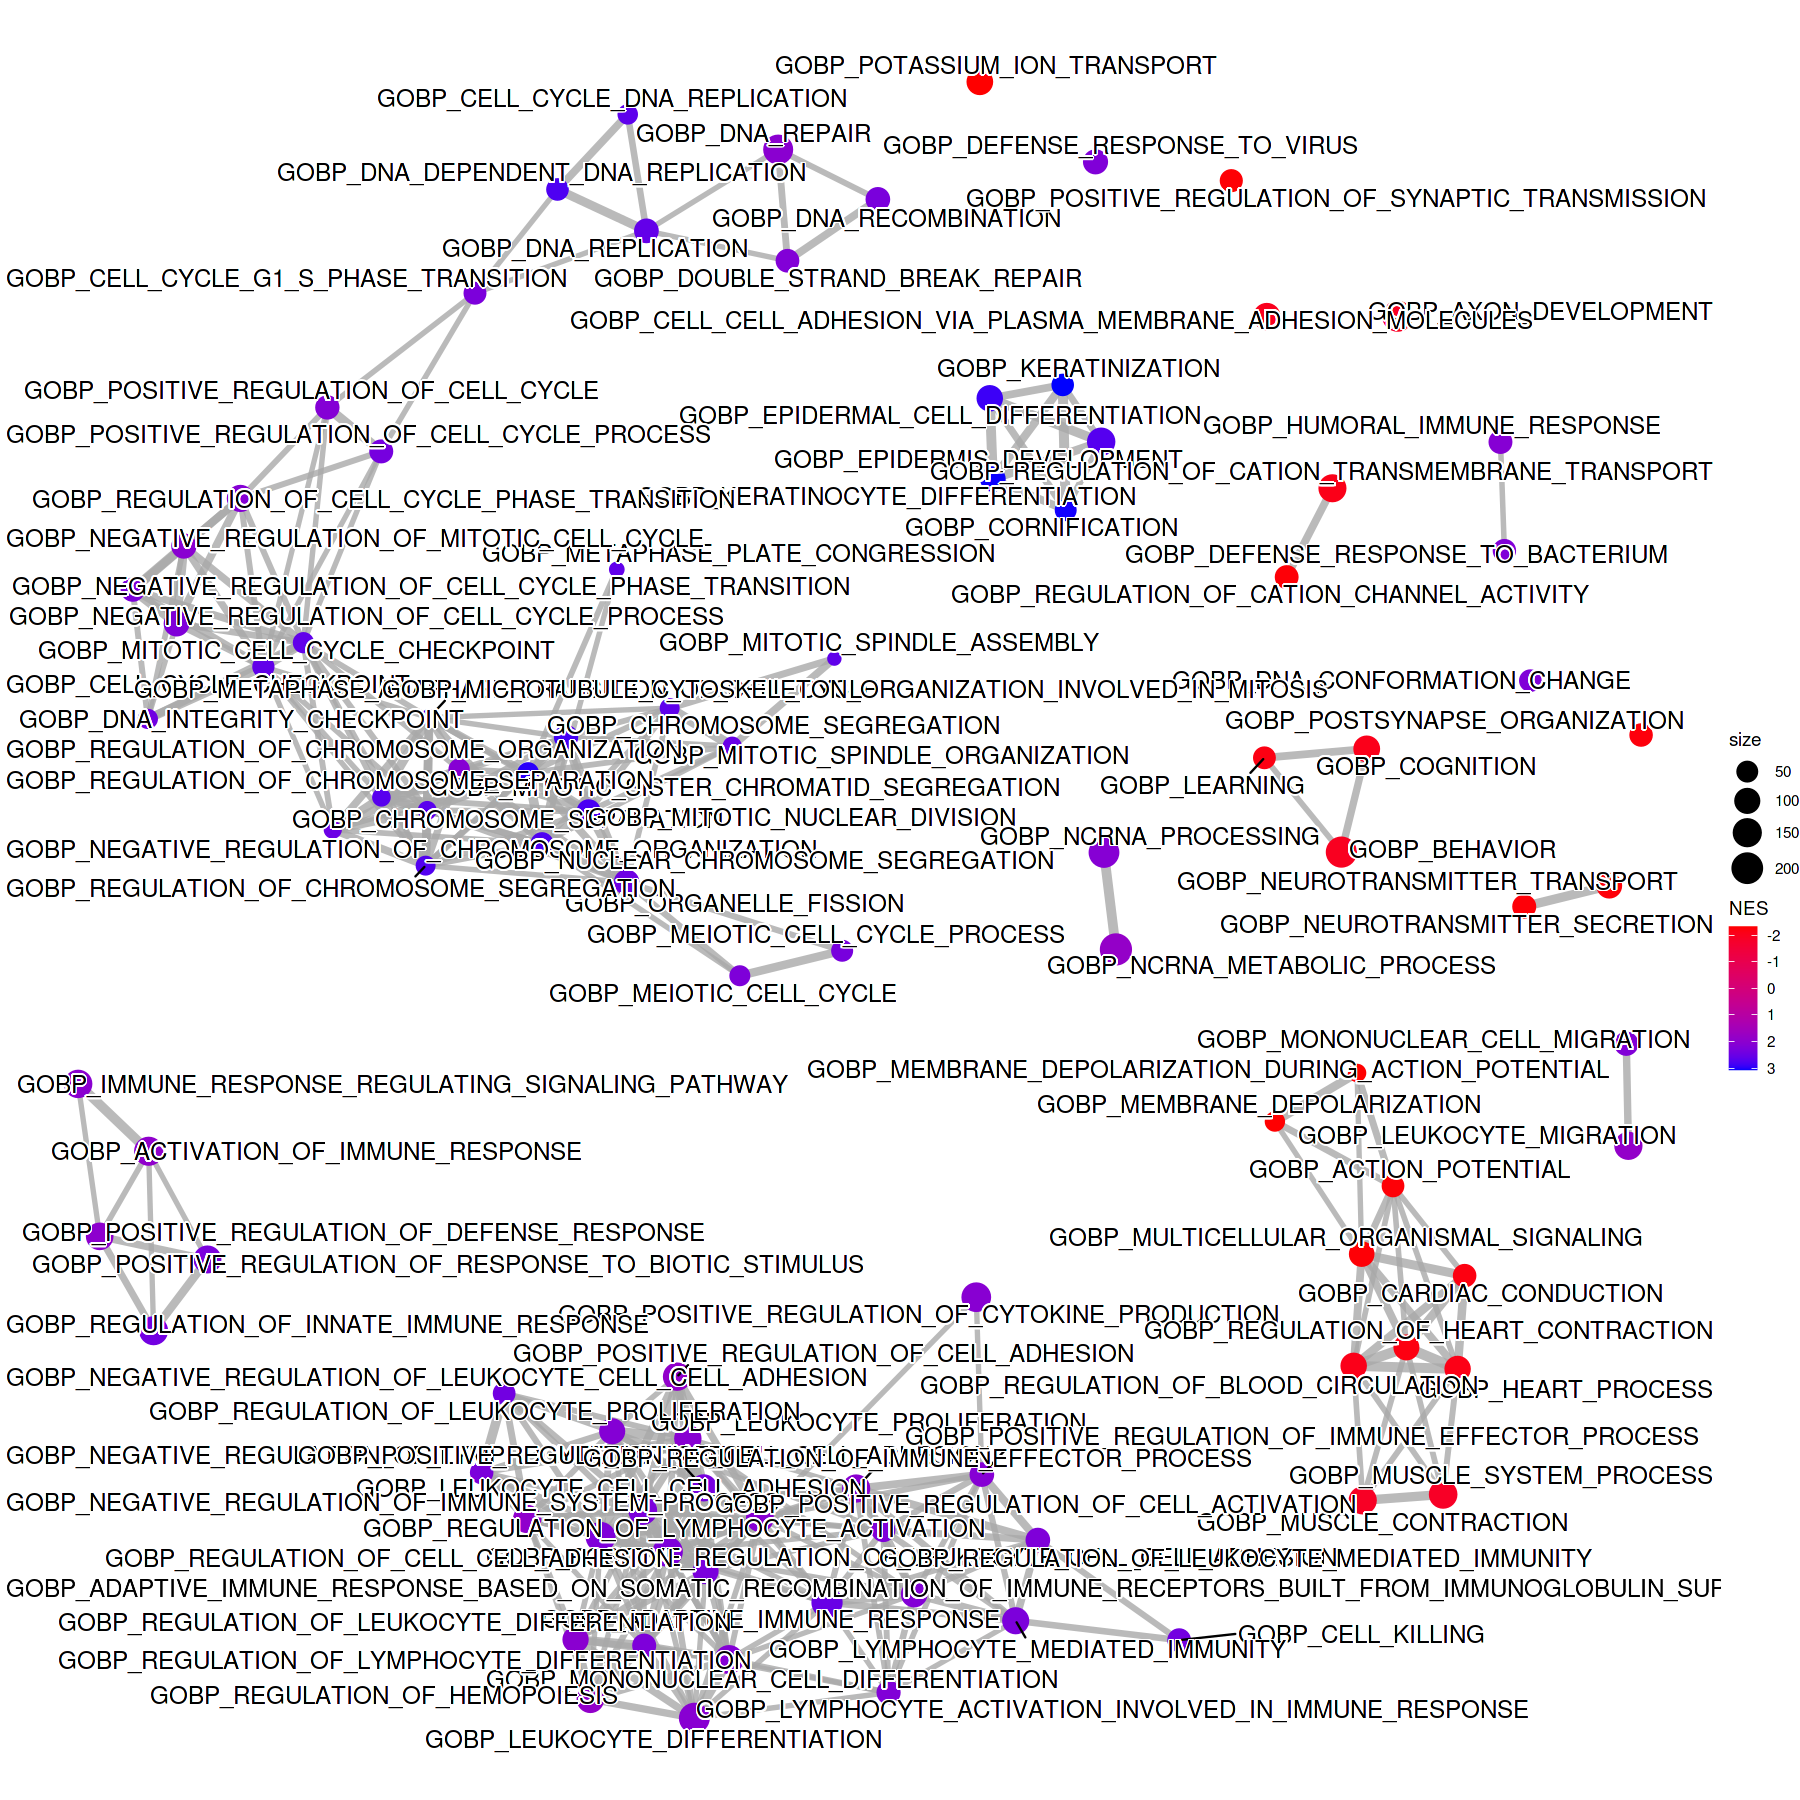

In [12]:
options(repr.plot.height = 15, repr.plot.width = 15)
p

### GOBP_REGULATION_OF_ORGANIC_ACID_TRANSPORT

In [18]:
anno = vector()
Complement_Mut_matrix = NA
Complement_Wt_matrix = NA
for(i in setdiff(names(TCGA_PanCancer),c("DLBC","LAML"))){
    tmp_cohort = TCGA_cohort_cal_pm(TCGA_PanCancer,i,"GOBP_REGULATION_OF_ORGANIC_ACID_TRANSPORT","All","Others")
    RNA_ID = colnames(TCGA_PanCancer[[i]]$rna)
    tmp_mut = intersect(tmp_cohort$mut,RNA_ID)
    tmp_wt = intersect(tmp_cohort$wt,RNA_ID)
    Complement_Mut_matrix = cbind(Complement_Mut_matrix,TCGA_PanCancer[[i]]$rna[tmp_mut])
    Complement_Wt_matrix = cbind(Complement_Wt_matrix,TCGA_PanCancer[[i]]$rna[tmp_wt])
    anno = rbind(anno,data.frame(Patient=tmp_mut,Cancer_Type=rep(i,length(tmp_mut)),Complement=rep("Mutation",length(tmp_mut))))
    anno = rbind(anno,data.frame(Patient=tmp_wt,Cancer_Type=rep(i,length(tmp_wt)),Complement=rep("Wildtype",length(tmp_wt))))
    
}
rownames(anno) = anno$Patient
anno$Patient = NULL

Complement_Mut_matrix$Complement_Mut_matrix = NULL
Complement_Wt_matrix$Complement_Wt_matrix = NULL

In [19]:
All_RNA = cbind(Complement_Mut_matrix,Complement_Wt_matrix)

In [20]:
m = apply(All_RNA,1,function(x){sum(x>0)>ncol(Complement_Mut_matrix)})
tmp_data = All_RNA[m,]

In [21]:
group = factor(c(rep("Mutation",ncol(Complement_Mut_matrix)),rep("Wildtype",ncol(Complement_Wt_matrix))),levels = c("Mutation","Wildtype"))
design = model.matrix(~0+group)
rownames(design) = colnames(tmp_data)
colnames(design) = c("Mutation","Wildtype")
  
fit = lmFit(tmp_data,design)
contr = makeContrasts(Mutation-Wildtype,levels = design)
diff = contrasts.fit(fit,contr)
diff = eBayes(diff)
tab = topTable(diff, sort.by = "P", n = Inf)

In [22]:
FC = tab$logFC
names(FC) = rownames(tab)
FC = sort(FC,decreasing = T)

In [23]:
KEGG = msigdbr(species="Homo sapiens",category="C2",subcategory = "CP:KEGG") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
REACTOME = msigdbr(species="Homo sapiens",category="C2",subcategory = "CP:REACTOME") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
HALLMARK = msigdbr(species="Homo sapiens",category="H") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
GO_BP = msigdbr(species="Homo sapiens",category="C5",subcategory = "GO:BP") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
GO_CC = msigdbr(species="Homo sapiens",category="C5",subcategory = "GO:CC") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
GO_MF = msigdbr(species="Homo sapiens",category="C5",subcategory = "GO:MF") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)

In [24]:
res = GSEA(geneList = FC,TERM2GENE = GO_BP[,c(1,3)],pvalueCutoff = 1)

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



In [25]:
res@result

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GOBP_ACTION_POTENTIAL,GOBP_ACTION_POTENTIAL,GOBP_ACTION_POTENTIAL,125,-0.6437438,-2.268180,1e-10,3.321622e-09,2.302276e-09,2794,"tags=48%, list=15%, signal=41%",KCNA2/GNA14/BIN1/KCNIP2/SLC8A1/KCNJ8/KCNE4/CLDN19/RYR2/SCN8A/KCNN2/KCND2/CTNNA3/AKAP6/SCN5A/KCND3/SCN7A/GJA1/CHRNB2/SLC4A3/SNTA1/SCN11A/KCNJ5/SLC8A2/SCN1B/GPR88/KCNMB4/KCNMB2/TAC1/ANK2/DMD/KCNA1/GRIK2/CACNA1C/ANK3/KCNH2/ADRA1A/FGF13/CACNA1I/KCNA5/CNR1/CACNA1H/CACNA1D/CACNA2D1/SCN2A/SCN3A/KCNC2/CACNA1G/FGF12/SCN4A/CHRNA4/HCN4/KCNJ3/SCN4B/CACNB2/KCNB1/SCN2B/SCN3B/NTRK2/ATP1A2
GOBP_ACTIVATION_OF_IMMUNE_RESPONSE,GOBP_ACTIVATION_OF_IMMUNE_RESPONSE,GOBP_ACTIVATION_OF_IMMUNE_RESPONSE,421,0.4547054,2.125699,1e-10,3.321622e-09,2.302276e-09,3368,"tags=36%, list=18%, signal=30%",MUC5B/CEACAM1/AIM2/C4BPA/MUC13/MUC4/KCNN4/CTLA4/CD79A/MUC2/MUC16/CD19/MUC1/CD3D/LGALS3/ZBP1/FPR2/LAX1/C4BPB/C2/PYHIN1/CPN1/LCK/FCRL3/PTPN22/MICB/CD55/CD3E/KLRD1/FOXP3/CD3G/MUC21/GBP1/IL1B/ARPC1B/SLA2/MUC17/ITK/MS4A1/UBASH3A/ZAP70/SH2D1A/CR2/CD209/ZC3H12A/FCGR2B/CCR7/PYCARD/IFI16/CD247/CR1/TRAT1/NOD2/KRT1/FCGR2A/CPB2/GRAP2/ADA/PSMB9/NFKBIZ/TNFRSF21/MUC7/CD38/HHLA2/BTNL8/FPR3/PAX5/MYO1G/PLSCR1/MYO10/TXK/CLEC6A/RUNX1/RPS6KA5/HLA-DQA1/THEMIS/KLHL6/SKAP1/CLEC4E/BTNL3/PIK3CD/HLA-DQA2/BLK/FCN1/CD28/TEC/RELB/BCL10/FCGR3A/LCP2/CLEC4D/HLA-DQB1/PSME2/PSMB8/HLA-DRB1/FCER1G/HLA-DRA/PTPRC/ACTR3/PSMB10/NFATC2/LILRB4/PSMD11/FFAR2/HLA-A/CLEC10A/CD226/RIPK2/NRAS/LYN/BTN1A1/HLA-DRB5/C1QB/NCR3/LAT/CD79B/CSK/MUC6/PSMA5/ICAM3/SYK/C1QC/ARPC2/C1S/HLA-DQB2/PAG1/CBFB/PSME3/PSMB2/PSMD12/SRC/PRKDC/BTN3A2/ARPC5/PSMD2/ACTB/ACTR2/BTN2A2/CBLB/PSMA7/C1R/HCK/ACTG1/PAWR/BTN3A1/MYO1C/CD276/C1QA/VAV1/FCGR1A/PSMB4
GOBP_ADAPTIVE_IMMUNE_RESPONSE,GOBP_ADAPTIVE_IMMUNE_RESPONSE,GOBP_ADAPTIVE_IMMUNE_RESPONSE,381,0.5841696,2.713370,1e-10,3.321622e-09,2.302276e-09,3285,"tags=52%, list=18%, signal=44%",CXCL13/EXO1/CEACAM1/C4BPA/SLAMF7/IRF4/CTLA4/CD79A/IFNG/LAG3/LAMP3/LILRA3/TFRC/CD7/PRF1/PLA2G4A/PDCD1/BATF/TNFRSF17/CD19/EOMES/CD3D/LAX1/ICAM1/C4BPB/IL4I1/C2/MICB/CD55/CD3E/SIT1/KLRD1/SLAMF6/LILRA6/FOXP3/SLAMF1/CD3G/IL1B/TAP1/SLA2/LY9/LILRB3/CD80/IL12RB1/MCOLN2/IL20RB/ITK/CD27/CD6/CD8A/ALOX15/CTSC/ZAP70/ENTPD7/SH2D1A/IRF1/CR2/CD209/ZC3H12A/FCGR2B/ZNF683/IL6/XCL1/TAP2/UNC13D/CTSS/LILRB2/TNFRSF13C/PYCARD/ANXA1/CD247/CR1/IL7R/TRAT1/CD244/CD70/HLA-DOB/CD274/GZMM/NOD2/BCL3/CD8B/TBX21/FOXJ1/FGA/EMP2/ADA/RIPK3/TNFAIP3/NFKBIZ/TNFSF13B/LEF1/LTA/TNFRSF21/DUSP10/TLR8/BTNL8/CD48/RNF19B/MYO1G/TNFRSF13B/CD1A/TXK/JAK3/IL6R/CLEC6A/LILRB5/SH2D1B/HLA-DQA1/MYD88/THEMIS/KLRC1/BTLA/HLA-F/KLHL6/PDCD1LG2/TCIRG1/SKAP1/IL23A/TNFRSF14/PIK3CD/CCL19/HLA-DQA2/HLA-E/RNF168/HLA-DMA/UNC93B1/CD28/TEC/RELB/BCL10/IL27RA/TNFRSF11A/CLEC4D/TNF/ORAI1/HLA-DQB1/IL27/HLA-DRB1/KLRK1/FCER1G/HLA-DRA/PRR7/PTPRC/SPN/LILRB4/HLA-A/SLC11A1/ADCY7/FCRL4/CLEC10A/IL10/CD226/RIPK2/HLA-B/SAMSN1/CCR2/LYN/IRF7/PRDM1/HLA-DRB5/C1QB/IL18/LAT/CD79B/CSK/DCLRE1C/IL17RA/CD74/SYK/ADAM17/NFKB2/C1QC/C1S/HLA-DQB2/HLA-H/PVR/HLA-C/LILRB1/PAG1/CD84/IL23R/CD86/BTN3A2/FZD5/HSPD1/IL4R/FUT7/CLCF1/CD40LG/SASH3/C1R/BTN3A1/HPRT1/HFE/IL18BP/C1QA/FGB
GOBP_ADAPTIVE_IMMUNE_RESPONSE_BASED_ON_SOMATIC_RECOMBINATION_OF_IMMUNE_RECEPTORS_BUILT_FROM_IMMUNOGLOBULIN_SUPERFAMILY_DOMAINS,GOBP_ADAPTIVE_IMMUNE_RESPONSE_BASED_ON_SOMATIC_RECOMBINATION_OF_IMMUNE_RECEPTORS_BUILT_FROM_IMMUNOGLOBULIN_SUPERFAMILY_DOMAINS,GOBP_ADAPTIVE_IMMUNE_RESPONSE_BASED_ON_SOMATIC_RECOMBINATION_OF_IMMUNE_RECEPTORS_BUILT_FROM_IMMUNOGLOBULIN_SUPERFAMILY_DOMAINS,241,0.5119874,2.278264,1e-10,3.321622e-09,2.302276e-09,3764,"tags=50%, list=20%, signal=41%",CXCL13/EXO1/CEACAM1/C4BPA/IRF4/TFRC/PRF1/PLA2G4A/BATF/CD19/ICAM1/C4BPB/C2/CD55/KLRD1/SLAMF6/FOXP3/IL1B/SLA2/LY9/CD80/IL12RB1/IL20RB/CD27/CD8A/CTSC/ENTPD7/CR2/ZC3H12A/FCGR2B/IL6/XCL1/UNC13D/ANXA1/CR1/IL7R/CD70/CD274/GZMM/NOD2/BCL3/TBX21/FOXJ1/EMP2/ADA/RIPK3/TNFAIP3/NFKBIZ/TNFSF13B/LEF1/LTA/TLR8/MYO1G/CD1A/JAK3/IL6R/MYD88/KLRC1/HLA-F/KLHL6/TCIRG1/IL23A/CCL19/

In [26]:
x2 <- pairwise_termsim(res,showCategory = 100)
p = emapplot(x2,showCategory = 100,color="NES",min_edge = 0.25,layout = "fr")

Warning message:
“ggrepel: 58 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


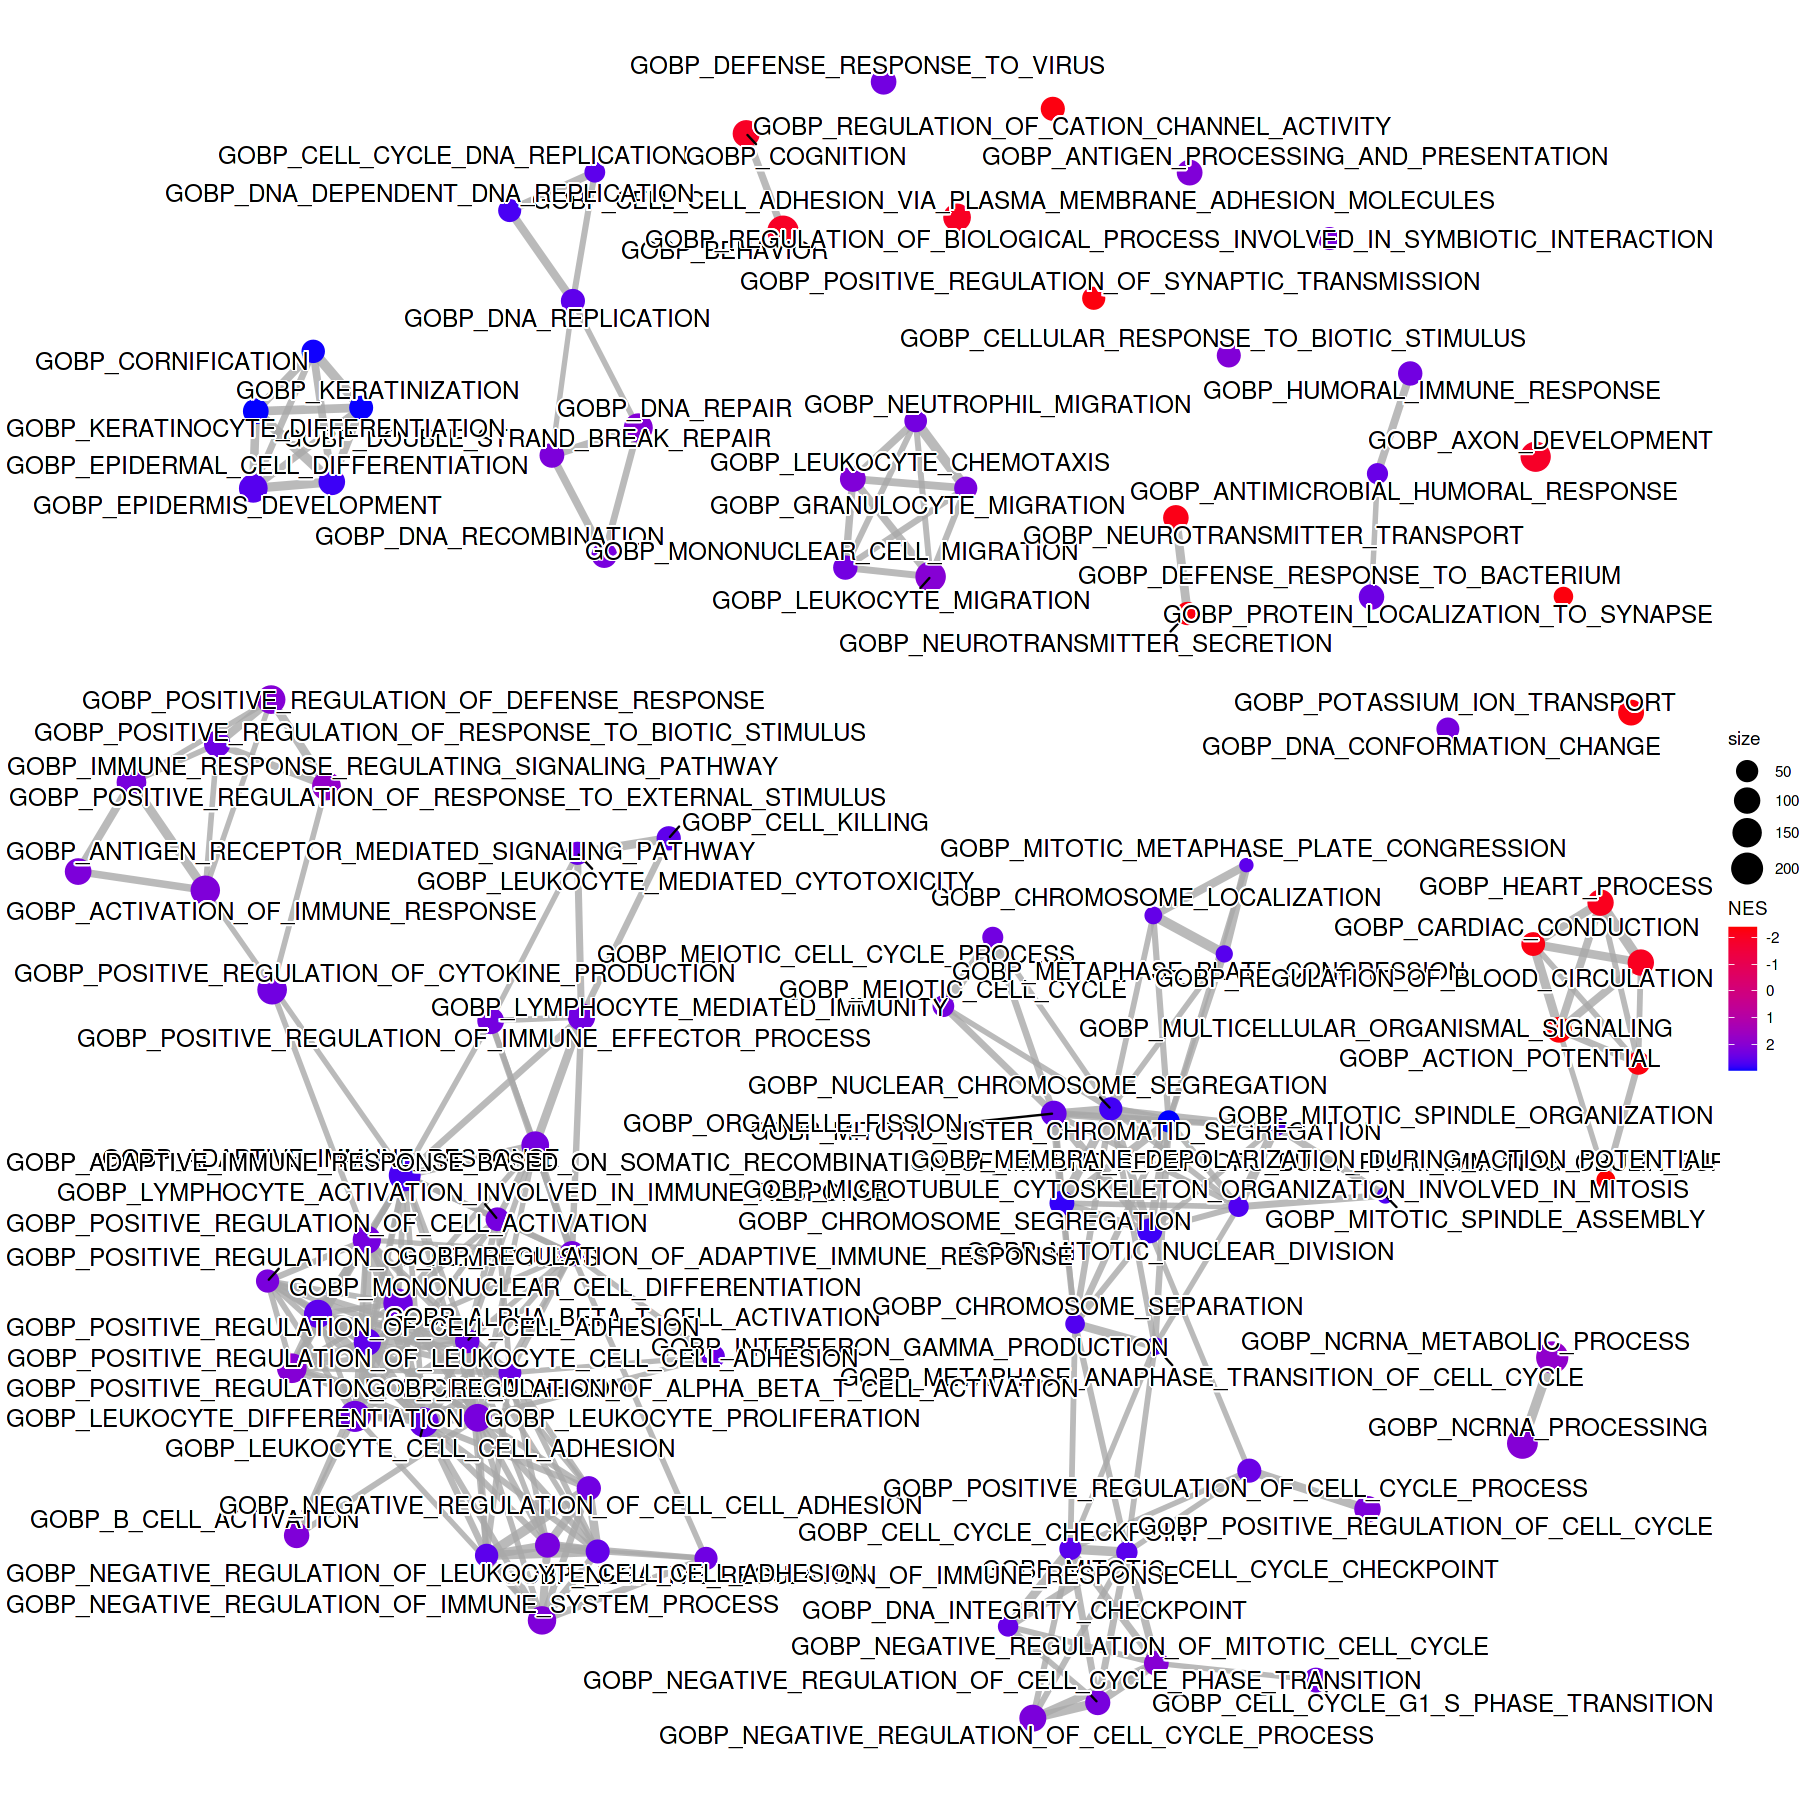

In [27]:
options(repr.plot.height = 15, repr.plot.width = 15)
p

### GOBP_CELLULAR_RESPONSE_TO_HEAT 

In [33]:
anno = vector()
Complement_Mut_matrix = NA
Complement_Wt_matrix = NA
for(i in setdiff(names(TCGA_PanCancer),c("DLBC","LAML"))){
    tmp_cohort = TCGA_cohort_cal_pm(TCGA_PanCancer,i,"GOBP_CELLULAR_RESPONSE_TO_HEAT","All","Others")
    RNA_ID = colnames(TCGA_PanCancer[[i]]$rna)
    tmp_mut = intersect(tmp_cohort$mut,RNA_ID)
    tmp_wt = intersect(tmp_cohort$wt,RNA_ID)
    Complement_Mut_matrix = cbind(Complement_Mut_matrix,TCGA_PanCancer[[i]]$rna[tmp_mut])
    Complement_Wt_matrix = cbind(Complement_Wt_matrix,TCGA_PanCancer[[i]]$rna[tmp_wt])
    anno = rbind(anno,data.frame(Patient=tmp_mut,Cancer_Type=rep(i,length(tmp_mut)),Complement=rep("Mutation",length(tmp_mut))))
    anno = rbind(anno,data.frame(Patient=tmp_wt,Cancer_Type=rep(i,length(tmp_wt)),Complement=rep("Wildtype",length(tmp_wt))))
    
}
rownames(anno) = anno$Patient
anno$Patient = NULL

Complement_Mut_matrix$Complement_Mut_matrix = NULL
Complement_Wt_matrix$Complement_Wt_matrix = NULL

In [34]:
All_RNA = cbind(Complement_Mut_matrix,Complement_Wt_matrix)

In [35]:
m = apply(All_RNA,1,function(x){sum(x>0)>ncol(Complement_Mut_matrix)})
tmp_data = All_RNA[m,]

In [36]:
group = factor(c(rep("Mutation",ncol(Complement_Mut_matrix)),rep("Wildtype",ncol(Complement_Wt_matrix))),levels = c("Mutation","Wildtype"))
design = model.matrix(~0+group)
rownames(design) = colnames(tmp_data)
colnames(design) = c("Mutation","Wildtype")
  
fit = lmFit(tmp_data,design)
contr = makeContrasts(Mutation-Wildtype,levels = design)
diff = contrasts.fit(fit,contr)
diff = eBayes(diff)
tab = topTable(diff, sort.by = "P", n = Inf)

In [37]:
FC = tab$logFC
names(FC) = rownames(tab)
FC = sort(FC,decreasing = T)

In [38]:
KEGG = msigdbr(species="Homo sapiens",category="C2",subcategory = "CP:KEGG") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
REACTOME = msigdbr(species="Homo sapiens",category="C2",subcategory = "CP:REACTOME") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
HALLMARK = msigdbr(species="Homo sapiens",category="H") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
GO_BP = msigdbr(species="Homo sapiens",category="C5",subcategory = "GO:BP") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
GO_CC = msigdbr(species="Homo sapiens",category="C5",subcategory = "GO:CC") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)
GO_MF = msigdbr(species="Homo sapiens",category="C5",subcategory = "GO:MF") %>% dplyr::select(gs_name, entrez_gene, gene_symbol)

In [39]:
res = GSEA(geneList = FC,TERM2GENE = GO_BP[,c(1,3)],pvalueCutoff = 1)

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



In [40]:
res@result

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GOBP_ACTION_POTENTIAL,GOBP_ACTION_POTENTIAL,GOBP_ACTION_POTENTIAL,122,-0.6273221,-2.237055,1e-10,3.43169e-09,2.355819e-09,2608,"tags=48%, list=14%, signal=42%",KCNJ8/SCN5A/KCND2/SCN8A/GJA1/GNA14/BIN1/KCNE4/CTNNA3/SCN11A/ANK3/KCNMB2/KCNMB4/KCNIP2/RYR2/GPR88/KCNA2/SNTA1/KCNJ5/SLC4A3/KCND3/CACNA1H/HCN2/SLC8A2/SCN1B/CACNA1C/SCN7A/KCNN2/TAC1/AKAP6/CHRNB2/DMD/FGF12/ADRA1A/SCN2A/KCNH2/CACNA2D1/CACNA1D/KCNA5/CNR1/FGF13/ANK2/KCNA1/CACNA1I/SCN4A/KCNJ3/GRIK2/CACNB2/CACNA1G/SCN3A/KCNC2/CHRNA4/HCN4/SCN4B/KCNB1/SCN3B/SCN2B/NTRK2/ATP1A2
GOBP_ACTIVATION_OF_IMMUNE_RESPONSE,GOBP_ACTIVATION_OF_IMMUNE_RESPONSE,GOBP_ACTIVATION_OF_IMMUNE_RESPONSE,407,0.4540468,2.056480,1e-10,3.43169e-09,2.355819e-09,4112,"tags=44%, list=23%, signal=35%",MUC5B/AIM2/MUC4/CEACAM1/C4BPA/MUC13/CTLA4/MUC1/KCNN4/MUC2/CD79A/MUC16/C2/ZC3H12A/FPR2/KRT1/ZBP1/CD3D/IL1B/LGALS3/LAX1/PYHIN1/KLRD1/MICB/PTPN22/LCK/C4BPB/GBP1/CD3E/CD19/CD3G/FCRL3/FOXP3/HHLA2/FCGR2B/TNFRSF21/CD55/CCR7/NOD2/ARPC1B/ITK/CR2/SLA2/PLSCR1/NFKBIZ/SKAP1/PYCARD/UBASH3A/IFI16/SH2D1A/PSMB9/CD247/ADA/ZAP70/MS4A1/MUC21/CD209/CPB2/FPR3/CR1/TRAT1/TXK/RUNX1/C1S/HLA-DQA2/FCGR2A/PAWR/GRAP2/RELB/PAX5/C1R/PSMB8/HLA-DQA1/PSMD11/BCL10/MUC20/VAV3/MYO1G/CLEC6A/CFB/HLA-A/FFAR2/CLEC4E/ACTR3/FCN1/PSME2/NRAS/HLA-DQB2/FCGR3A/PSMD12/LIME1/CD28/SRC/PSMB10/CLEC4D/HLA-DRB1/THEMIS/TEC/ARPC5/HLA-DQB1/PSMA5/HLA-DRA/BTNL8/PSMD2/LYN/CLEC10A/ARPC2/CARD11/RIPK2/FCER1G/PSMA7/LAT/PSMB2/NCR3/C5AR1/KLHL6/BTNL3/CD46/PSMA4/HLA-DRB5/CD38/PTPRC/PIK3CD/BTN3A2/PSME3/YES1/ACTR2/ACTB/PLEKHA1/VTCN1/SYK/BTN3A1/HCK/PRKDC/BLK/PSME4/RPS6KA5/CSK/C1QB/PSMA3/MYO10/PSMD14/PSMB3/PTPN2/PSMD7/CBFB/BTN1A1/PSMA6/LCP2/C1RL/BTN2A2/CD79B/PSMB4/MYO1C/CD276/CR1L/PTPN6/FGR/ARPC1A/LILRB4/FCN3/ICAM3/NFKBID/F2/CD226/C1QC/CFD/PAK2/CD300A/BAX/C1QA/ACTG1/PSMD3/PHB/STOML2/C1QBP/HSP90AA1/PSME1/CDC42/CBLB
GOBP_ADAPTIVE_IMMUNE_RESPONSE,GOBP_ADAPTIVE_IMMUNE_RESPONSE,GOBP_ADAPTIVE_IMMUNE_RESPONSE,368,0.5854176,2.624919,1e-10,3.43169e-09,2.355819e-09,3805,"tags=58%, list=21%, signal=47%",CXCL13/EXO1/CEACAM1/C4BPA/SLAMF7/LAMP3/IL20RB/CTLA4/TFRC/IRF4/IFNG/BATF/CD79A/LILRA3/LAG3/FGA/C2/PRF1/ZC3H12A/CD7/CD3D/PLA2G4A/TNFRSF17/IL4I1/IL1B/PDCD1/XCL1/ICAM1/EOMES/LAX1/KLRD1/IL6/MICB/CTSC/CD70/C4BPB/LILRA6/ENTPD7/CD3E/TAP1/CD19/SLAMF6/CD3G/CD80/FOXP3/ALOX15/SLAMF1/IL7R/LILRB3/BCL3/EMP2/SIT1/IRF1/FCGR2B/TNFRSF21/CD55/CD6/NOD2/UNC13D/ITK/LY9/HLA-DOB/CR2/SLA2/NFKBIZ/FGB/SKAP1/MCOLN2/TNFAIP3/TAP2/ANXA1/PYCARD/CD8A/CTSS/DUSP10/SH2D1A/CD27/IL12RB1/LILRB2/CD247/ADA/ZAP70/CD274/CD209/IL23A/ZNF683/CD1A/HLA-F/CD244/CR1/CD8B/TRAT1/TXK/JAK3/C1S/RNF19B/FCAMR/IL18/HLA-DQA2/MYD88/TLR8/TBX21/SH2D1B/TNFRSF13C/RELB/UNC93B1/CD48/GZMM/C17orf99/KLRC1/RNF168/TCIRG1/LTA/C1R/RIPK3/IL4R/TNFRSF13B/TNFSF13B/SLC11A1/HLA-DQA1/BCL10/HLA-B/MYO1G/HLA-E/PDCD1LG2/TNFRSF11A/CLEC6A/CLCF1/HLA-A/HLA-DQB2/TNFRSF14/HFE/IL6R/TNF/PVR/IL27/IL18R1/LIME1/CD28/IL27RA/ADAM17/CLEC4D/HLA-DRB1/HLA-C/LILRB5/IL10/HLA-G/ORAI1/THEMIS/HLA-H/TEC/HPRT1/HLA-DQB1/HLA-DRA/BTLA/BTNL8/DCLRE1C/IRF7/LYN/CLEC10A/NFKB2/HLA-DMA/FOXJ1/RIPK2/FCER1G/PRR7/PRDM1/FCRL4/LAT/CCR2/SAMSN1/ADCY7/KLHL6/CD46/SPN/HLA-DRB5/IL17RA/KLRK1/PTPRC/CTSH/PIK3CD/BTN3A2/HSPD1/FZD5/ZP3/JAG1/IL23R/VTCN1/MICA/SYK/BTN3A1/CD86/CCL19/CSK/CLC/C1QB/ZBTB7B/CD74/CD40LG/C1RL/EXOSC3/CD79B/LILRB1/PTPN6/FUT7/LILRB4/TRPM4/RAG1/ERAP1/NFKBID/FADD/CD226/IFNE/C1QC/TNFRSF1B
GOBP_ADAPTIVE_IMMUNE_RESPONSE_BASED_ON_SOMATIC_RECOMBINATION_OF_IMMUNE_RECEPTORS_BUILT_FROM_IMMUNOGLOBULIN_SUPERFAMILY_DOMAINS,GOBP_ADAPTIVE_IMMUNE_RESPONSE_BASED_ON_SOMATIC_RECOMBINATION_OF_IMMUNE_RECEPTORS_BUILT_FROM_IMMUNOGLOBULIN_SUPERFAMILY_DOMAINS,GOBP_ADAPTIVE_IMMUNE_RESPONSE_BASED_ON_SOMATIC_RECOMBINATION_OF_IMMUNE_RECEPTORS_BUILT_FROM_IMMUNOGLOBULIN_SUPERFAMILY_DOMAINS,234,0.5271526,2.284240,1e-10,3.43169e-09,2.355819e-09,3805,"tags=53%, list=21%, signal=42%",CXCL13/EXO1/CEACAM1/C4BPA/IL20RB/TFRC/IRF4/BATF/C2/PRF1/ZC3H12A/PLA2G4A/IL1B/XCL1/ICAM1/KLRD1/IL6/CTS

In [41]:
x2 <- pairwise_termsim(res,showCategory = 100)
p = emapplot(x2,showCategory = 100,color="NES",min_edge = 0.25,layout = "fr")

Warning message:
“ggrepel: 55 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


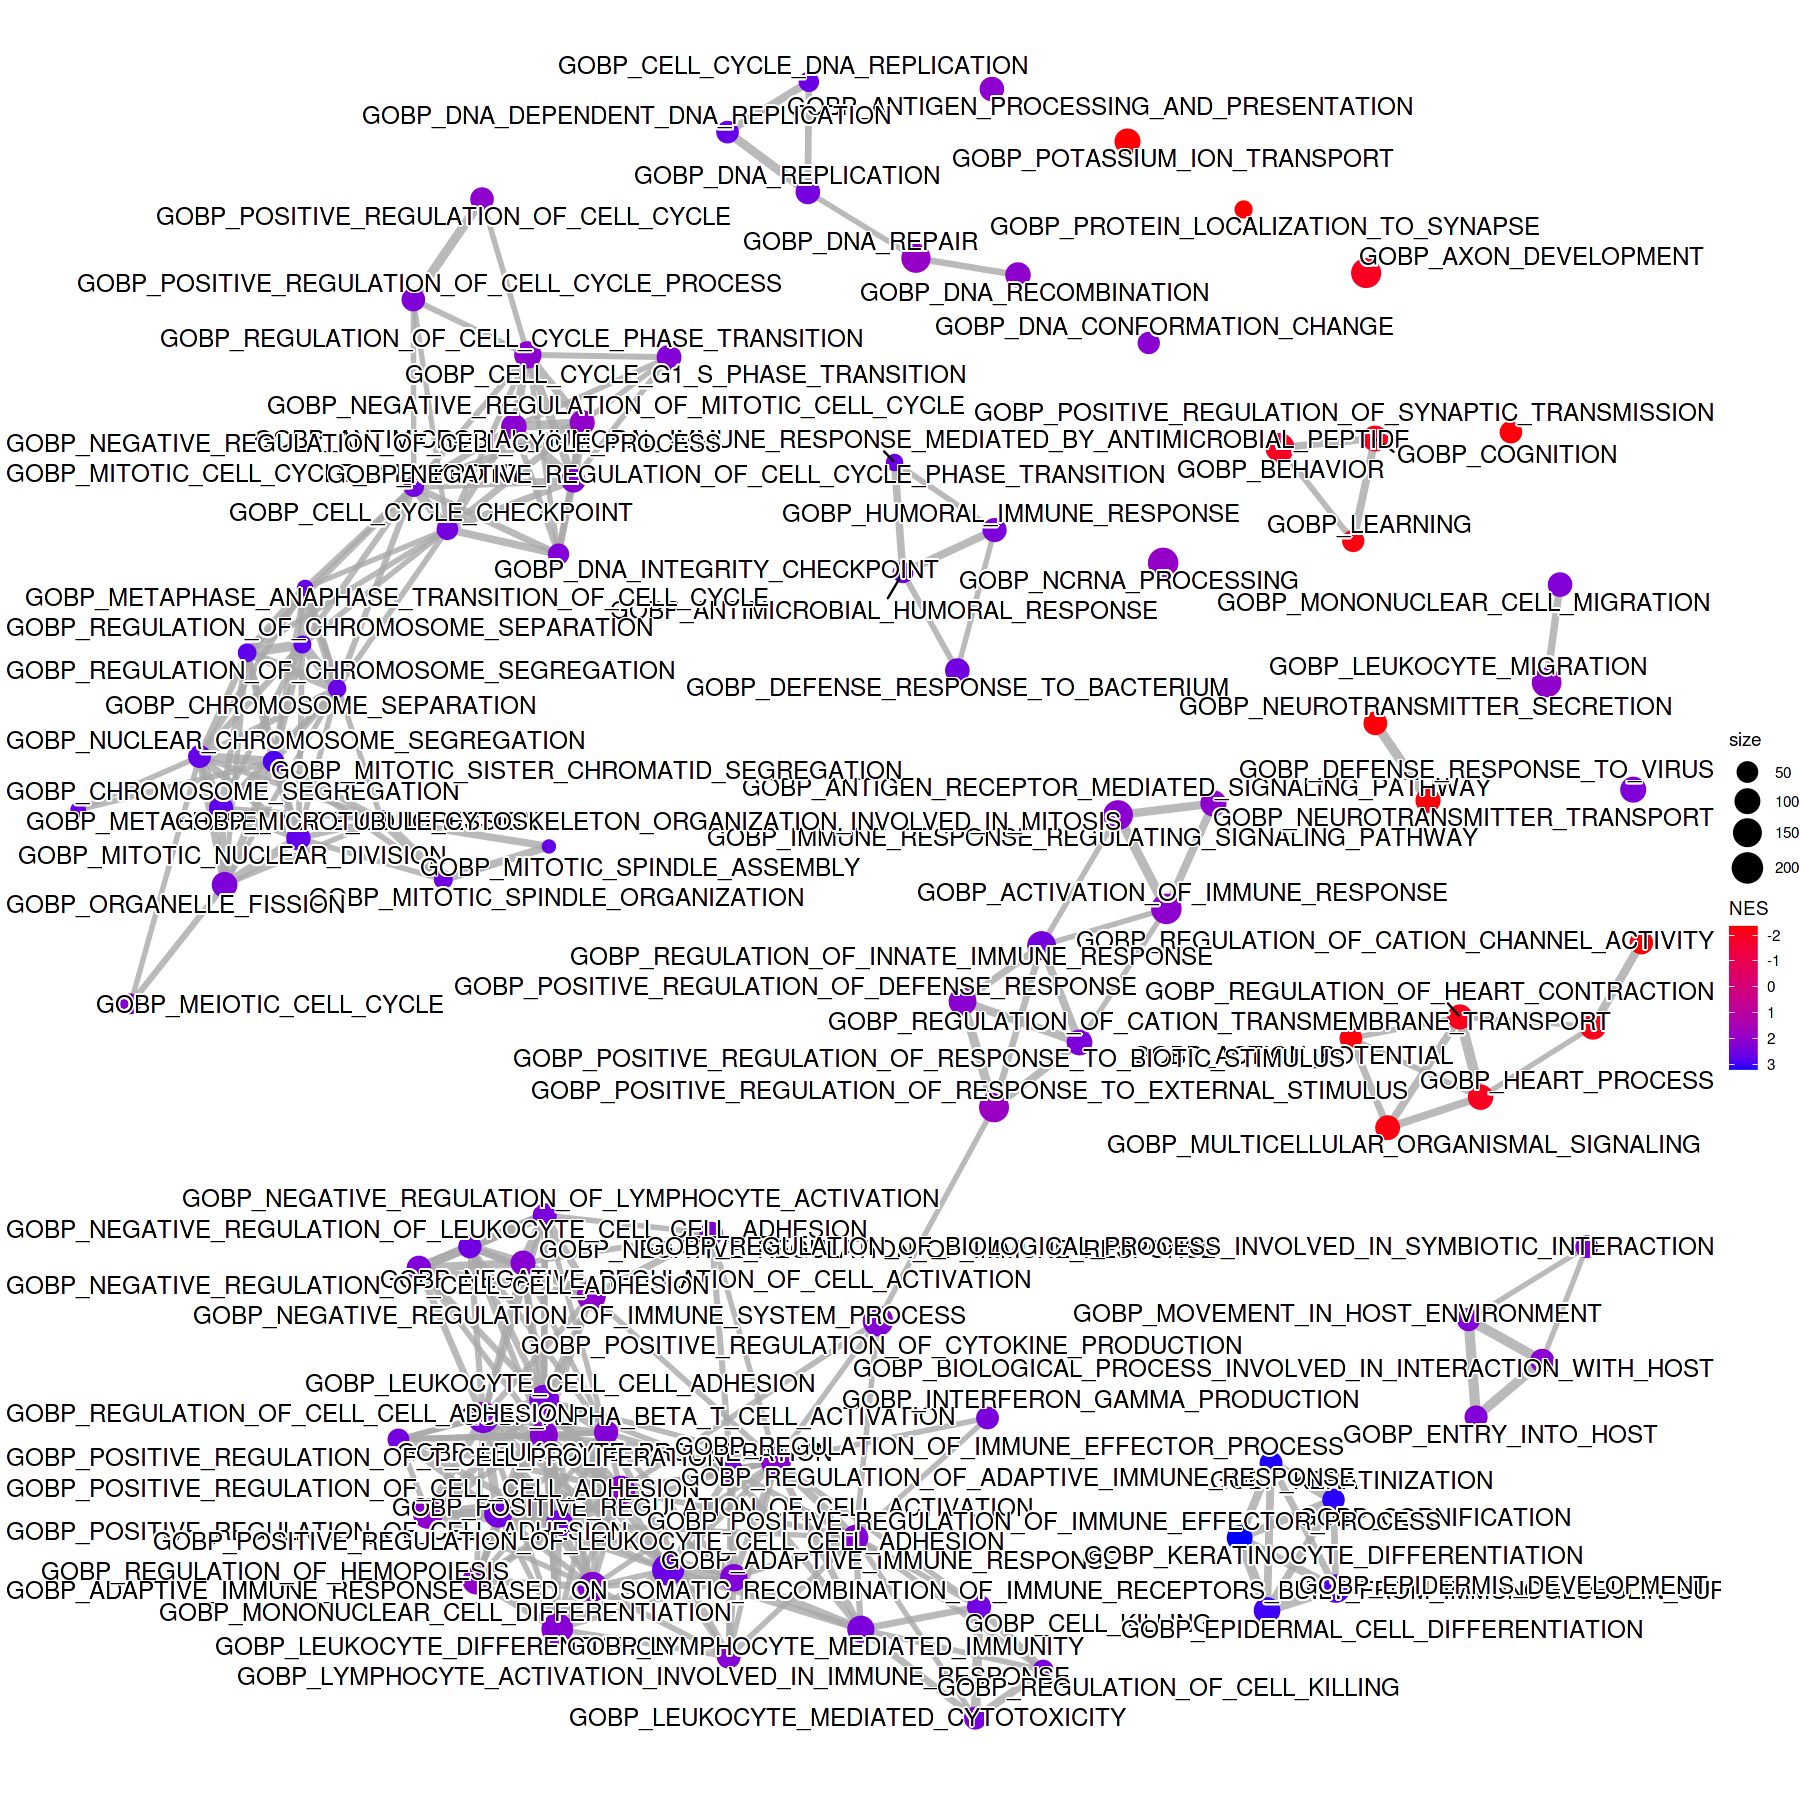

In [42]:
options(repr.plot.height = 15, repr.plot.width = 15)
p